In [14]:
import numpy as np
from collections import defaultdict
import random
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

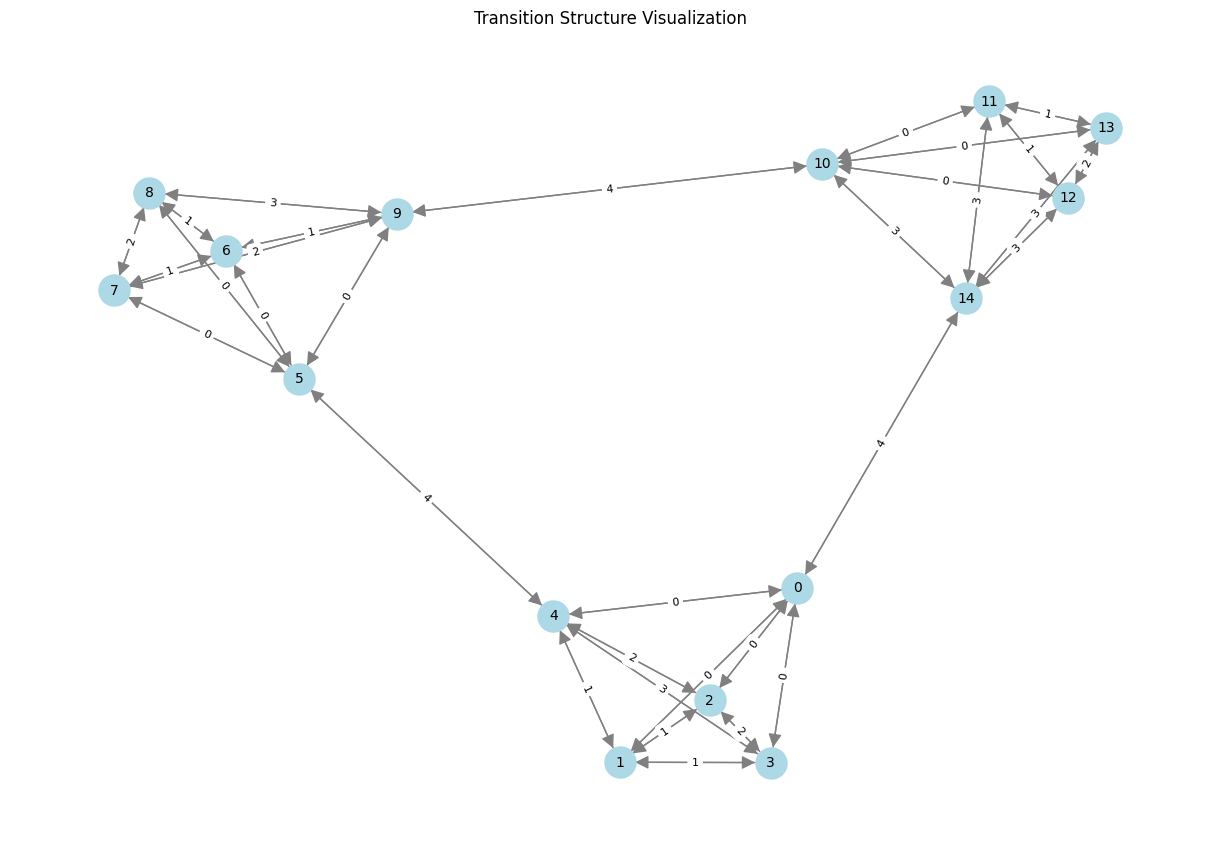

In [23]:
import numpy as np
import random
import networkx as nx
import matplotlib.pyplot as plt

def create_modular_graph_varied_with_visualization(
    num_nodes=15, num_observations=10000, num_aliased_states=10, num_modules=3
):
    if num_nodes < 4:
        raise ValueError("num_nodes must be at least 4 to allow for meaningful connectivity.")

    if num_nodes < num_modules:
        raise ValueError("Number of nodes must be at least equal to the number of modules to form a meaningful structure.")

    # Initialize the adjacency list for variable actions per node
    adjacency_list = {node: [] for node in range(num_nodes)}

    # Calculate the size of each module
    module_size = num_nodes // num_modules

    for module_index in range(num_modules):
        module_start = module_index * module_size
        # For the last module, extend to the end of the node list
        module_end = module_start + module_size if module_index < num_modules - 1 else num_nodes

        # Fully connect nodes within the module
        for i in range(module_start, module_end):
            for j in range(module_start, module_end):
                if i != j:
                    adjacency_list[i].append(j)

    # Optionally, add sparse inter-module connections
    for module_index in range(num_modules - 1):
        module_end = (module_index + 1) * module_size - 1
        next_module_start = (module_end + 1) % num_nodes
        adjacency_list[module_end].append(next_module_start)
        adjacency_list[next_module_start].append(module_end)

    # Connect first and last module
    adjacency_list[0].append(num_nodes - 1)
    adjacency_list[num_nodes - 1].append(0)

    # Generate observations based on random walks on the lattice graph
    states = [np.random.choice(range(num_nodes))]  # Start from a random state
    actions = []  # Keep track of the actions taken

    for _ in range(1, num_observations):
        current_state = states[-1]
        # Actions correspond to outbound connections for the current node
        outbound_connections = adjacency_list[current_state]
        action = np.random.choice(len(outbound_connections))  # Choose an action
        next_state = outbound_connections[action]  # Follow the chosen action
        states.append(next_state)
        actions.append(action)

    # Map states to observations with aliasing
    if num_aliased_states > num_nodes or num_aliased_states < 1:
        raise ValueError("num_aliased_states must be between 1 and the number of nodes.")

    unique_obs = np.arange(num_nodes - num_aliased_states)
    for n in range(num_aliased_states):
        unique_obs = np.append(unique_obs, random.choice(unique_obs))
    state_to_obs = unique_obs  # Aliasing version

    # Create observation data
    x = state_to_obs[states]

    # Create a transition graph using networkx
    G = nx.DiGraph()
    for node, neighbors in adjacency_list.items():
        for idx, neighbor in enumerate(neighbors):
            G.add_edge(node, neighbor, action=idx)

    return x, actions, G

# Visualization function for the graph
def visualize_transition_graph(G):
    pos = nx.spring_layout(G)  # Position nodes for visualization
    plt.figure(figsize=(12, 8))
    edge_labels = nx.get_edge_attributes(G, "action")  # Get edge attributes

    # Draw the graph
    nx.draw(
        G,
        pos,
        with_labels=True,
        node_color="lightblue",
        edge_color="gray",
        node_size=500,
        font_size=10,
        arrowsize=20,
    )
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    plt.title("Transition Structure Visualization")
    plt.show()

# Example usage
x, actions, G = create_modular_graph_varied_with_visualization(
    num_nodes=15, num_observations=1000, num_aliased_states=3, num_modules=3
)
visualize_transition_graph(G)


In [49]:
# Create observation data
num_nodes=30
num_observations=1000
num_modules=3
aliasing=3

num_aliased_states = num_nodes//aliasing
# observations = create_modular_graph_varied(num_nodes, num_observations, num_aliased_states, num_modules)
observations, actions, G = create_modular_graph_varied_with_visualization(
    num_nodes=15, num_observations=1000, num_aliased_states=3, num_modules=3
)
# actions = np.zeros(len(observations), dtype=int)

In [42]:
# Count occurrences of each unique value
unique, counts = np.unique(observations, return_counts=True)
# Create a dictionary of the counts
result = dict(zip(unique, counts))

print("Counts of 0, 1, 2, 3:")
print(result)

Counts of 0, 1, 2, 3:
{0: 84, 1: 188, 2: 79, 3: 134, 4: 109, 5: 70, 6: 57, 7: 45, 8: 43, 9: 64, 10: 71, 11: 56}


In [43]:
np.unique(observations)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11])

In [44]:
np.unique(actions)

array([0, 1, 2, 3, 4])

In [39]:
# @nb.njit
class Agent:
    def __init__(self, num_obs=4, num_actions=4, pseudocount=1e-3):
        self.num_obs = num_obs
        self.groups_of_tables = {}
        self.table_totals = {}  # Keep track of totals for each table separately
        self.total_observations = 0  # Keep track of total observations across all tables
        self.count = np.ones((num_obs,num_obs,num_actions))
        self.TM = self.count.copy()
        self.normalize_TM()
        self.initialize_clones(num_obs)
        self.pseudocount = pseudocount


    def initialize_clones(self,num_obs):
        for restaurant_id in range(num_obs):
            self.groups_of_tables[restaurant_id] = {}
            self.groups_of_tables[restaurant_id][0] = 1
    
    def normalize_TM(self):
        num_obs = np.shape(self.count)[0]
        num_actions = np.shape(self.count)[2]
        count = self.count.copy()
        for s in range(num_obs):
            for a in range(num_actions):
                self.TM[s, :, a] = count[s,:,a] / count[s,:,a].sum()
                
                
    def add_clone(self, restaurant_id, table_id):
        """Add exactly one clone to a specified table, creating the table or group if necessary."""
        # Automatically create the group and table if they don't exist
        if restaurant_id not in self.groups_of_tables:
            self.groups_of_tables[restaurant_id] = {}
        if table_id not in self.groups_of_tables[restaurant_id]:
            self.groups_of_tables[restaurant_id][table_id] = 0  # Initialize clones count for the table

        # Add one clone to the table count and update total observations
        self.groups_of_tables[restaurant_id][table_id] += 1
        self.table_totals[(restaurant_id, table_id)] = self.groups_of_tables[restaurant_id][table_id]  # Update table total
        self.total_observations += 1

    def get_total_observations(self):
        """Return the total number of observations."""
        return self.total_observations

    def get_restaurant_total_customers(self, restaurant_id):
        """Return the total number of clones in all tables within a specific restaurant."""
        return sum(self.groups_of_tables.get(restaurant_id, {}).values())

    def get_table_total_customers(self, restaurant_id, table_id):
        """Return the total number of clones for a specific table."""
        return self.groups_of_tables.get(restaurant_id, {}).get(table_id, 0)
    
#     def get_prior_distribution(self):

#         return [self.get_restaurant_total_customers(restaurant_id for restaurant_id in range(self.num_obs))
#                 /self.get_total_observations()]

    def count_tables_in_restaurant(self, restaurant_id):
        """Returns the number of tables within the specified restaurant."""
        if restaurant_id in self.groups_of_tables:
            return len(self.groups_of_tables[restaurant_id])
        else:
            # print(f"Group {group_id} does not exist.")
            return 0
        
# agent.update_count((total_clones, prev_action, obs_ind))
    def expand_split_TM(self):
        # expand dimension
        orig_count = self.count.copy()
        orig_TM = self.TM.copy()
        n_prev_clones = np.shape(orig_count)[0]
        n_actions = np.shape(orig_count)[2]
        expanded_count = np.zeros((n_prev_clones+1, n_prev_clones+1, n_actions)) + self.pseudocount
        expanded_TM = np.zeros((n_prev_clones+1, n_prev_clones+1, n_actions)) + self.pseudocount
                
        # Copy the original matrix values into the top-left submatrix of the expanded matrix
        expanded_count[:n_prev_clones, :n_prev_clones, :] = orig_count
        expanded_TM[:n_prev_clones, :n_prev_clones, :] = orig_TM
        
        self.count = expanded_count
        self.TM = expanded_TM
        
# #         self.count[state, state2]
#         for ss in state2:
#             self.count[state, ss, action] += 1
            
    def update_count(self, state, state2, action): # updating counts when not splitted
#         for ss in state2: 
#         self.count[state, state2]
#         for ss in state2:
        self.count[state, state2, action] += 1

        
#         for next_state in state2: 
            
#     def update_transition(self, state, state2, action): 
#         # update transition probability p(s'|s,a)
#         self.TM[state, state2, action] += 1
        
#         # Normalize the probabilities for the current state and action
#         self.TM[state, :, action] /= self.TM[state, :, action].sum()        
    def merged_likelihood(self, clone_map):
        
        merged_TM = self.TM.copy()
        
        curr_obs, clone_num, unique_idx = random.choice(clone_map)
        shared_obs_clones = [t for t in clone_map if t[0]==curr_obs and t[1] != clone_num] # all the clones that share the obs
        
        compare_clones = random.choice(shared_obs_clones) # pick a random clone that shares observation 

        state_a = unique_idx
        state_b = compare_clones[2]
        
        for s in range(len(clone_map)):
            if s != state_a and s != state_b:                
                merged_TM[state_a][s] += merged_TM[state_b][s]
                merged_TM[s][state_a] += merged_TM[s][state_b] 
                # Remove state_b by zeroing out probabilities (optional)
                merged_TM[state_b][s] = 0
                merged_TM[s][state_b] = 0
                
        
def CRP(agent, curr_observation, alpha=1.0, beta=1.0):
    """
    Simulates the Chinese Restaurant Process.

    Parameters:
    - history: int, the total number of customers to simulate.
    - alpha: float, the concentration parameter.

    Returns:
    - A list where the i-th element represents the table number of the i-th customer.
    """

    n = agent.get_restaurant_total_customers(curr_observation)


    if curr_observation not in agent.groups_of_tables:
        agent.add_clone(curr_observation,0)
        table_choice = 0
        assignments = 0
        probs = 1
    else:
        
        probs = [clone_count / (n + alpha) for table_id, clone_count in 
               agent.groups_of_tables[curr_observation].items()] + [alpha / (n + alpha)] # This is the prior
#         print(probs)
    
#     probs = np.concatenate(probs)
#     print(probs)
    # Add an update rule (ref Nora's paper 1st equation)

    # Choose a table based on the probabilities
    table_choice = np.random.choice(len(probs), p=probs)


    # update clone --> existing or new, same
    agent.add_clone(curr_observation,table_choice)
    assignments = table_choice

    return assignments, probs


def get_distribution(data):
    """
    Compute the probability distribution from a nested dictionary structure.

    Parameters:
        data (dict): A nested dictionary where the outer keys map to inner dictionaries
                     containing counts for different elements.

    Returns:
        np.ndarray: A NumPy array containing the probability distribution.
    """
    # Flatten the dictionary and compute total count
    flattened_counts = defaultdict(int)
    total_count = 0
    ct = 0
    for outer_key, inner_dict in data.items():
#         print(outer_key)
        for inner_key, count in inner_dict.items():
#             print(inner_key)
            flattened_counts[ct] += count
            total_count += count
            ct += 1

    # Compute probabilities as a sorted NumPy array
    sorted_keys = sorted(flattened_counts.keys())
    probabilities = np.array([flattened_counts[key] / total_count for key in sorted_keys])

    return probabilities
def forward_algorithm(agent, prior, observations, actions, clone_map, clone_history, TM):
#     prior = get_distribution(agent.groups_of_tables)
#     print(prior)
#         TM = self.TM.copy()
    num_steps = len(observations)
    num_states = np.shape(TM)[0]

    log_forward_probs = np.full((num_states, num_steps), 0)  # Use -inf for log(0)

    initial_state = observations[0]
    for s in range(num_states):
        if s == initial_state:
#             forward_probs[s, 0] = prior[s]
            log_forward_probs[s,0] = prior[s]
        else:
#             forward_probs[s, 0] = 0  # Probability is zero if it doesn't match initial state
            log_forward_probs[s,0] = 0


    for t in range(1, num_steps):



        current_clone = [clone[2] for clone in clone_map 
                         if clone[0]==clone_history[t][0] and clone[1]==clone_history[t][1]]
    #     print(current_clone)
    #         current_state = clone_history[t][1] #states_sequence[t]
    #         current
        prev_action = actions[t-1]

        for s in range(num_states):
#             if s == current_clone[0]:
#                 forward_probs[s, t] = sum(
#                     forward_probs[prev_s, t-1] * agent.TM[prev_s, s, prev_action]
#                     for prev_s in range(num_states)
#                 )
#                 print(forward_probs[s,t])

                log_forward_probs[s, t] = np.logaddexp.reduce([
                    log_forward_probs[prev_s, t-1] + np.log(TM[prev_s, s, prev_action])
                    for prev_s in range(num_states)
                ])

    return np.sum(log_forward_probs)
# def clean_clone_map(data, delete_obs, delete_clone, delete_unique_id):
def clean_clone_map(data, delete_items):
#     delete_obs = []
#     delete_clone = []
#     delete_unique_id = []
#     for items in delete_items:
#         delete_obs.append(items[0])
#         delete_clone.append(items[1])
#         delete_unique_id.append(items[2])
        
#     updated_data = []
#     offset = 0  # Track the number of removed IDs
#     for x, y, uid in data:
#         if uid in delete_unique_ids:
#             offset += 1  # Increment offset for each deleted ID
#         else:
#             updated_data.append((x, y-1, uid - offset))  # Adjust the ID by the offset
#     return updated_data


#     updated_data = [
#         (x, y-1, uid - 1 if uid > delete_unique_id else uid)
#         for x, y, uid in data
#         if uid != delete_unique_id
#     ]
#     return updated_data

    updated_data=[]
    for ids in delete_items: 
        for x,y,uid in data: 
            if uid < ids[2]:
                updated_data.append((x,y,uid))
            elif uid > ids[2]: 
                if x != ids[0]: 
                    updated_data.append((x,y,uid-1))
                else:
                    updated_data.append((x,y-1,uid-1))
#             else: 
#                 if x==ids[0]: 
#                     updated_data.append((x,y-1,uid-1))
    return updated_data

def viterbi_decoding(agent):
    TM = agent.TM.copy()
    n_states = np.shape(TM)[0]
    n_actions = np.shape(TM)[2]
    for s1 in range(n_states):
    #         for s2 in range(n_states):
        TM_t = np.transpose(TM[s1])
        for action in range(n_actions):
            currTM = TM_t[action]

            for e,element in enumerate(currTM): 
                if element == np.max(currTM):
                    TM[s1][e][action]=1
                else:
                    TM[s1][e][action]=0
    #         sns.heatmap(TM[s1][e])
    #         plt.show()
#             print(TM[s1][e])
    return TM



def sigmoid(x):
    """
    Compute the sigmoid of x.
    
    Parameters:
    - x: A scalar, vector, or matrix.
    
    Returns:
    - Sigmoid of x.
    """
    return 1 / (1 + np.exp(-x))


In [51]:
pseudocount=1e-3
np.random.seed(42)

alpha = 1
n_iter = 10 #100
n_particles = 5
n_actions = len(np.unique(actions))
n_obs = len(np.unique(observations))
scaling_factor = 3
pes = []
agent = Agent(num_obs=n_obs, num_actions=n_actions,pseudocount=pseudocount)
for i in range(n_iter): 
    
    # 1. SPLITTING
    print('Splitting: iteration {}'.format(i))
    print('TM size: {}'.format(np.shape(agent.TM)))
    clone_history = []
    if i==0: # first iteration        
        clone_map= []   
        # initialize clones for each obs
        for obs in range(n_obs):
            clone_map.append((obs,0,obs))    
        unique_clone_id = n_obs-1
    else: 
        unique_clone_id = len(clone_map)-1
    lik_orig = 0
    for o, obs in enumerate(observations): 
        if o < 2:
            clone_history.append((obs,0, obs))
            # update transition
            if o ==1:
                agent.update_count(observations[o-1], observations[o], actions[o]) # update transition between t-1 and t-2
                agent.normalize_TM()                        
            continue # skip 1st observation
            
            
        splitted = False
        
        prev_prev_action = actions[o-2]
        prev_action = actions[o-1]
        prev_obs = observations[o-1]
        prev_tables = agent.count_tables_in_restaurant(prev_obs)
        # get the PE using the transition matrix
        
        prev_ind = [t[2] for t in clone_map if t[0]==prev_obs]
        # Get all state, actions that lead to current obs:
        obs_ind = [t[2] for t in clone_map if t[0]==obs] # this is list of curr obs clone id
        PE = 0
        for oi in obs_ind: # all possible clones related to current observation
            for pi in prev_ind: # all possible clones related to t-1 observation
            
                PE += agent.TM[pi, oi, prev_action] # just sum up PEs for now
#         PE = 
        pes.append(PE)
        assignment, _ =  CRP(agent, prev_obs, alpha=scaling_factor/PE)
        
        post_tables = agent.count_tables_in_restaurant(prev_obs)
        if prev_tables != post_tables: # a new clone has been created for this observation

            splitted = True
            unique_clone_id += 1
            clone_map.append((prev_obs, assignment, unique_clone_id))
            agent.expand_split_TM()
            prev_clone = unique_clone_id # clone id of t-1 : unique
            
        else:

            prev_clone = [t[2] for t in clone_map if t[0]==obs and t[1]==assignment] # clone id of t-1 revealed
        prev_prev_obs, prev_prev_assignment, prev_prev_clone = clone_history[-1]
#         if i > 0: 
#             print(clone_history)
        agent.update_count(prev_prev_clone, prev_clone, prev_prev_action) # update transition between t-1 and t-2
        agent.normalize_TM()

        clone_history.append((prev_obs, assignment, prev_clone)) # this keeps track of observation & clone history

    # 2. FORWARD ALGORITHM TO GET LIKELIHOOD
    TM = agent.TM.copy()
    prior = get_distribution(agent.groups_of_tables)
    log_lik = forward_algorithm(agent, prior, observations, actions, clone_map, clone_history, TM)
#     print(log_lik)
    print('Log lik for split iteration {}: {}'.format(i, log_lik))
    
            
    # 3. MERGING

    for particle in range(n_particles): # many hypotheses // can this be parallelized?
        print("Particle {}".format(particle))
        curr_obs, clone_num, unique_idx = random.choice(clone_map)
        shared_obs_clones = [t for t in clone_map if t[0]==curr_obs and t[1] != clone_num] # all the clones that share the obs
    #     prev_ind = [t[2] for t in clone_map if t[0]==prev_obs]
    #     _, clone_id = clone_list[idx]
        # do the merging by iterating over other clones
        # in the sequence, find other clones that could be merged with the current
        
#         compare_clones = random.choice(shared_obs_clones) # pick a random clone that shares observation 
        #### make this selection anti-proportional to number of assigned observations
        distribution = [agent.groups_of_tables[curr_obs][v[1]] for v in shared_obs_clones]
        distribution = np.array(distribution).astype(np.float64)
        inverted_probs = 1 / distribution
        inverted_probs[distribution == 0] = 0  # Handle zero probabilities if present
        normalized_probs = inverted_probs / inverted_probs.sum()
#         selected_element = np.random.choice(shared_obs_clones, p=normalized_probs)
        
        # Randomly select an element based on probabilities
        compare_clones = shared_obs_clones[np.random.choice(len(shared_obs_clones), p=normalized_probs)]        

        state_a = unique_idx
        state_b = compare_clones[2]
        merged_TM = agent.TM.copy()

        # adjusting prior distribution
        merged_prior = get_distribution(agent.groups_of_tables)
        merged_prior[state_a] += merged_prior[state_b]
        merged_prior[state_b] = 0 #pseudocount    
        # adjusting TM
        for s in range(np.shape(agent.TM)[0]):
            if s != state_a and s != state_b:
                for a in range(len(np.unique(actions))):
                    merged_TM[state_a][s][a] += merged_TM[state_b][s][a]
                    merged_TM[s][state_a][a] += merged_TM[s][state_b][a]
                    merged_TM[s][state_b][a] = pseudocount
                    merged_TM[state_b][s][a] = pseudocount


        # Remove state_b by zeroing out probabilities (optional)
    #     agent.TM[state_b] = np.zeros(self.num_states)    

        # Get the new prior
    #     new_prior = # GET THE NEW DISTRIBUTION

        # Get the new likelihood by forward algorithm
    #     new_lik = new_prior * new_Tm
        new_lik = forward_algorithm(agent, merged_prior, observations, actions, clone_map, clone_history, merged_TM)
    #     print(log_lik, new_lik)
        if new_lik > log_lik: # if merging is better: 
            agent.TM = merged_TM
            agent.groups_of_tables[curr_obs][clone_num] += agent.groups_of_tables[curr_obs][compare_clones[1]]
            agent.groups_of_tables[curr_obs][compare_clones[1]] = 0
            print("Merged Obs {} clone {} into clone {}, log lik: {}".format(curr_obs, compare_clones[1], clone_num, new_lik))
            
            
            # clean up clones (including values that are 0)
            print(agent.groups_of_tables[curr_obs])
            orig_table = agent.groups_of_tables[curr_obs].copy()
#             print(orig_table)
            orig_table[compare_clones[1]] = 0
            delete_indices = [o for o,i in enumerate(orig_table) if orig_table[i]==0]
            # Get unique IDs for the delete_indices from clone_map
            delete_items = [
                t for t in clone_map
                for d in delete_indices
                if t[0] == curr_obs and t[1] == d
            ]
#                     delete_uniqueids = [
#                 t[2] for t in clone_map
#                 for d in delete_indices
#                 if t[0] == curr_obs and t[1] == d
#             ]
            new_table = {}
            ni = 0
            for i in range(len(orig_table)):
#                 print(orig_table[i])
                if orig_table[i] != 0: 
                    new_table[ni] = orig_table[i]
                    ni+=1
            agent.groups_of_tables[curr_obs] = new_table
#             print(agent.groups_of_tables[curr_obs])
            
            # clean up TM
            for d in delete_items:
#                 if d >= np.shape(agent.TM)[0]: # MAYBE 
                agent.TM = np.delete(np.delete(agent.TM, d[2], axis=0), d[2], axis=1)

            # clean up COUNT
#             for d in delete_items: 
                agent.count = np.delete(np.delete(agent.count, d[2], axis=0), d[2], axis=1)     
            agent.normalize_TM()
                
            # clean up clone_map
#             print(clone_map)
#             for ids in delete_uniqueids: 
#                 print(ids)
#                 def clean_clone_map(data, delete_obs, delete_clone, delete_unique_id):
            clone_map = clean_clone_map(clone_map, delete_items)
#             print(clone_map)
            print(np.shape(agent.TM))
            
                        
            log_lik = new_lik    
# ####### maybe instead of doing particle filter totally randomly, this can be rule-based too
# ####### for example, proportional to clones with least number of tables will be more likely to be pruned
# ####### probability for being selected == inverse of customers
    
    
    
#         # merge according to number of particles, and update them if they improved
                
# prev_prev_clone, prev_clone, prev_prev_action

Splitting: iteration 0
TM size: (12, 12, 5)
Log lik for split iteration 0: 5460
Particle 0
Particle 1
Particle 2
Particle 3
Particle 4
Splitting: iteration 1
TM size: (136, 136, 5)
Log lik for split iteration 1: 8486
Particle 0
Particle 1
Particle 2
Particle 3
Particle 4
Splitting: iteration 2
TM size: (156, 156, 5)
Log lik for split iteration 2: 9798
Particle 0
Particle 1
Particle 2
Particle 3
Particle 4
Splitting: iteration 3
TM size: (161, 161, 5)
Log lik for split iteration 3: 10170
Particle 0
Particle 1
Particle 2
Particle 3
Merged Obs 9 clone 6 into clone 2, log lik: 10261
{0: 66, 1: 31, 2: 11, 3: 54, 4: 38, 5: 215, 6: 0, 7: 14, 8: 2, 9: 31, 10: 5, 11: 43, 12: 4, 13: 12, 14: 4, 15: 2, 16: 1}
(166, 166, 5)
Particle 4
Splitting: iteration 4
TM size: (166, 166, 5)
Log lik for split iteration 4: 10987
Particle 0
Particle 1
Particle 2
Particle 3
Particle 4
Splitting: iteration 5
TM size: (170, 170, 5)
Log lik for split iteration 5: 12817
Particle 0
Particle 1
Particle 2
Particle 3
Par

KeyboardInterrupt: 

In [10]:
np.unique(observations)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [12]:
np.unique(actions)

array([0])

In [459]:
#2. Batch updating (recommended to begin with this)


room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)
actions, observations, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room
pseudocount=1e-3
np.random.seed(42)
agent = Agent(pseudocount=pseudocount)
alpha = 1
n_iter = 1 #100
n_particles = 50
n_actions = len(np.unique(actions))
n_obs = len(np.unique(observations))
scaling_factor = 10
pes = []
for i in range(n_iter): 
    
    # 1. SPLITTING
    print('Splitting: iteration {}'.format(i))
    print('TM size: {}'.format(np.shape(agent.TM)))
    clone_history = []
    if i==0: # first iteration        
        clone_map= []   
        # initialize clones for each obs
        clone_map.append((0,0,0))
        clone_map.append((1,0,1))
        clone_map.append((2,0,2))
        clone_map.append((3,0,3))
    
        unique_clone_id =3
    else: 
        unique_clone_id = len(clone_map)-1
    lik_orig = 0
    for o, obs in enumerate(observations): 
        if o < 2:
            clone_history.append((obs,0, obs))
            # update transition
            if o ==1:
                agent.update_count(observations[o-1], observations[o], actions[o]) # update transition between t-1 and t-2
                agent.normalize_TM()                        
            continue # skip 1st observation
        splitted = False
        
        prev_prev_action = actions[o-2]
        prev_action = actions[o-1]
        prev_obs = observations[o-1]
        prev_tables = agent.count_tables_in_restaurant(prev_obs)
        # get the PE using the transition matrix
        
        prev_ind = [t[2] for t in clone_map if t[0]==prev_obs]
        # Get all state, actions that lead to current obs:
        obs_ind = [t[2] for t in clone_map if t[0]==obs] # this is list of curr obs clone id
        PE = 0
        for oi in obs_ind: # all possible clones related to current observation
            for pi in prev_ind: # all possible clones related to t-1 observation
            
                PE += agent.TM[pi, oi, prev_action] # just sum up PEs for now
#         PE = 
        pes.append(PE)
        assignment, _ =  CRP(agent, prev_obs, alpha=scaling_factor/PE)
        
        post_tables = agent.count_tables_in_restaurant(prev_obs)
        if prev_tables != post_tables: # a new clone has been created for this observation

            splitted = True
            unique_clone_id += 1
            clone_map.append((prev_obs, assignment, unique_clone_id))
            agent.expand_split_TM()
            prev_clone = unique_clone_id # clone id of t-1 : unique
            
        else:

            prev_clone = [t[2] for t in clone_map if t[0]==obs and t[1]==assignment] # clone id of t-1 revealed
        prev_prev_obs, prev_prev_assignment, prev_prev_clone = clone_history[-1]
#         if i > 0: 
#             print(clone_history)
        agent.update_count(prev_prev_clone, prev_clone, prev_prev_action) # update transition between t-1 and t-2
        agent.normalize_TM()

        clone_history.append((prev_obs, assignment, prev_clone)) # this keeps track of observation & clone history

    # 2. FORWARD ALGORITHM TO GET LIKELIHOOD
    TM = agent.TM.copy()
    prior = get_distribution(agent.groups_of_tables)
    log_lik = forward_algorithm(agent, prior, observations, actions, clone_map, clone_history, TM)
#     print(log_lik)
    print('Log lik for split iteration {}: {}'.format(i, log_lik))
    
            
    # 3. MERGING

    for particle in range(n_particles): # many hypotheses // can this be parallelized?
        print("Particle {}".format(particle))
        curr_obs, clone_num, unique_idx = random.choice(clone_map[n_obs:])
        shared_obs_clones = [t for t in clone_map[n_obs:] if t[0]==curr_obs and t[1] != clone_num] # all the clones that share the obs
    #     prev_ind = [t[2] for t in clone_map if t[0]==prev_obs]
    #     _, clone_id = clone_list[idx]
        # do the merging by iterating over other clones
        # in the sequence, find other clones that could be merged with the current

        compare_clones = random.choice(shared_obs_clones) # pick a random clone that shares observation 
        #### make this selection anti-proportional to number of assigned observations???

        state_a = unique_idx
        state_b = compare_clones[2]
        merged_TM = agent.TM.copy()

        # adjusting prior distribution
        merged_prior = get_distribution(agent.groups_of_tables)
        merged_prior[state_a] += merged_prior[state_b]
        merged_prior[state_b] = 0 #pseudocount    
        # adjusting TM
        for s in range(np.shape(agent.TM)[0]):
            if s != state_a and s != state_b:
                for a in range(len(np.unique(actions))):
                    merged_TM[state_a][s][a] += merged_TM[state_b][s][a]
                    merged_TM[s][state_a][a] += merged_TM[s][state_b][a]
                    merged_TM[s][state_b][a] = pseudocount
                    merged_TM[state_b][s][a] = pseudocount


        # Remove state_b by zeroing out probabilities (optional)
    #     agent.TM[state_b] = np.zeros(self.num_states)    

        # Get the new prior
    #     new_prior = # GET THE NEW DISTRIBUTION

        # Get the new likelihood by forward algorithm
    #     new_lik = new_prior * new_Tm
        new_lik = forward_algorithm(agent, merged_prior, observations, actions, clone_map, clone_history, merged_TM)
    #     print(log_lik, new_lik)
        if new_lik > log_lik: # if merging is better: 
            agent.TM = merged_TM
            agent.groups_of_tables[curr_obs][clone_num] += agent.groups_of_tables[curr_obs][compare_clones[1]]
            agent.groups_of_tables[curr_obs][compare_clones[1]] = 0
            print("Merged Obs {} clone {} into clone {}, log lik: {}".format(curr_obs, compare_clones[1], clone_num, new_lik))
            
            
            # clean up clones (including values that are 0)
            print(agent.groups_of_tables[curr_obs])
            orig_table = agent.groups_of_tables[curr_obs].copy()
#             print(orig_table)
            orig_table[compare_clones[1]] = 0
            delete_indices = [o for o,i in enumerate(orig_table) if orig_table[i]==0]
            # Get unique IDs for the delete_indices from clone_map
            delete_items = [
                t for t in clone_map
                for d in delete_indices
                if t[0] == curr_obs and t[1] == d
            ]
#                     delete_uniqueids = [
#                 t[2] for t in clone_map
#                 for d in delete_indices
#                 if t[0] == curr_obs and t[1] == d
#             ]
            new_table = {}
            ni = 0
            for i in range(len(orig_table)):
#                 print(orig_table[i])
                if orig_table[i] != 0: 
                    new_table[ni] = orig_table[i]
                    ni+=1
            agent.groups_of_tables[curr_obs] = new_table
#             print(agent.groups_of_tables[curr_obs])
            
            # clean up TM
            for d in delete_items:
#                 if d >= np.shape(agent.TM)[0]: # MAYBE 
                agent.TM = np.delete(np.delete(agent.TM, d[2], axis=0), d[2], axis=1)

            # clean up COUNT
            for d in delete_items: 
                agent.count = np.delete(np.delete(agent.count, d[2], axis=0), d[2], axis=1)     
                
            # clean up clone_map
#             print(clone_map)
#             for ids in delete_uniqueids: 
#                 print(ids)
#                 def clean_clone_map(data, delete_obs, delete_clone, delete_unique_id):
            clone_map = clean_clone_map(clone_map, delete_items)
#             print(clone_map)
            print(np.shape(agent.TM))
            
                        
            log_lik = new_lik    
# ####### maybe instead of doing particle filter totally randomly, this can be rule-based too
# ####### for example, proportional to clones with least number of tables will be more likely to be pruned
# ####### probability for being selected == inverse of customers
    
    
    
#         # merge according to number of particles, and update them if they improved
                
# prev_prev_clone, prev_clone, prev_prev_action



Splitting: iteration 0
TM size: (4, 4, 4)
Log lik for split iteration 0: -399981
Particle 0
Merged Obs 2 clone 10 into clone 14, log lik: -386525
{0: 50, 1: 41, 2: 244, 3: 13, 4: 273, 5: 62, 6: 37, 7: 6, 8: 40, 9: 63, 10: 0, 11: 99, 12: 2, 13: 50, 14: 34, 15: 6, 16: 1, 17: 6, 18: 7, 19: 7, 20: 6, 21: 8, 22: 4, 23: 2}
(82, 82, 4)
Particle 1
Merged Obs 2 clone 16 into clone 17, log lik: -347479
{0: 50, 1: 41, 2: 244, 3: 13, 4: 273, 5: 62, 6: 37, 7: 6, 8: 40, 9: 63, 10: 99, 11: 2, 12: 50, 13: 34, 14: 6, 15: 1, 16: 0, 17: 13, 18: 7, 19: 6, 20: 8, 21: 4, 22: 2}
(81, 81, 4)
Particle 2
Merged Obs 2 clone 13 into clone 11, log lik: -313128
{0: 50, 1: 41, 2: 244, 3: 13, 4: 273, 5: 62, 6: 37, 7: 6, 8: 40, 9: 63, 10: 99, 11: 36, 12: 50, 13: 0, 14: 6, 15: 1, 16: 13, 17: 7, 18: 6, 19: 8, 20: 4, 21: 2}
(80, 80, 4)
Particle 3
Merged Obs 3 clone 1 into clone 3, log lik: -304247
{0: 322, 1: 0, 2: 210, 3: 184, 4: 25, 5: 136, 6: 4, 7: 96, 8: 76, 9: 118, 10: 107, 11: 5, 12: 9, 13: 7, 14: 35, 15: 26, 16: 1

In [451]:
pes

[0.25,
 0.2501874531367158,
 0.4165417291354322,
 0.24981264051961022,
 0.25000000000000006,
 0.4721598002496879,
 0.2518553852389732,
 0.43163100936996607,
 0.7499999999999998,
 1.8566871929759523,
 1.107018168863555,
 0.6784467402921265,
 0.5206698819625338,
 0.7624201915403033,
 0.6247507477567299,
 0.8740825130039306,
 0.955820055408159,
 0.7244590744375995,
 2.070687759834685,
 1.0883694887148423,
 1.13876432486298,
 0.6747912491526434,
 0.6747912491526434,
 1.3467806989862334,
 0.9993221690590113,
 1.351822849929288,
 2.1423324181903727,
 1.158966469070998,
 1.2994055680373504,
 1.921281004654348,
 2.729457448122529,
 2.4003138603855714,
 2.4071497978855723,
 3.3919146508994067,
 3.8254547875385656,
 2.0462733204668706,
 0.6345410191302636,
 0.656208596143125,
 1.1754909271687788,
 1.3319017247266822,
 2.432331036704751,
 1.3319017247266822,
 3.5446832413973763,
 2.0060282074613305,
 1.4703794170646856,
 3.129990689786299,
 3.351232817514915,
 1.0889374554705156,
 1.9594985597580

(array([4.811e+03, 1.410e+02, 2.300e+01, 1.300e+01, 1.000e+00, 3.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 5.000e+00]),
 array([ 0.90474429,  4.81726986,  8.72979543, 12.642321  , 16.55484657,
        20.46737214, 24.37989772, 28.29242329, 32.20494886, 36.11747443,
        40.03      ]),
 <BarContainer object of 10 artists>)

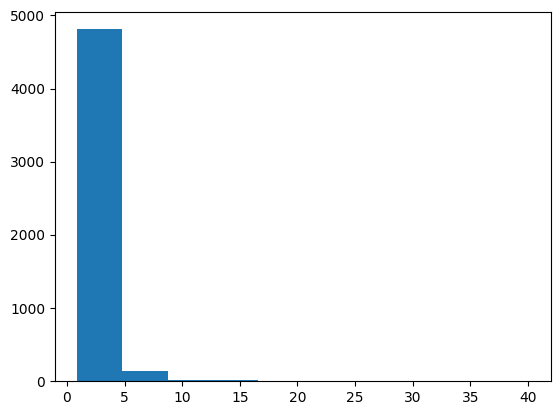

In [452]:
plt.hist(10/np.array(pes))

In [398]:
clone_history

[(3, 0, 3),
 (1, 0, 1),
 (1, 3, [14]),
 (3, 3, [19]),
 (1, 0, [0]),
 (0, 0, [2]),
 (2, 0, [3]),
 (3, 0, [2]),
 (2, 0, [0]),
 (0, 2, [6]),
 (0, 1, [5]),
 (0, 2, [6]),
 (0, 0, [2]),
 (2, 1, [4]),
 (3, 1, [7]),
 (2, 3, [19]),
 (1, 3, [19]),
 (1, 3, [19]),
 (1, 3, [19]),
 (1, 0, [1]),
 (1, 0, [1]),
 (1, 0, [0]),
 (0, 0, [3]),
 (3, 0, [3]),
 (3, 0, [3]),
 (3, 0, [2]),
 (2, 0, [2]),
 (2, 0, [2]),
 (2, 3, [14]),
 (3, 0, [3]),
 (3, 1, [4]),
 (3, 0, [3]),
 (3, 3, [9]),
 (2, 3, [14]),
 (3, 0, [3]),
 (3, 1, [4]),
 (3, 0, [3]),
 (3, 3, [13]),
 (0, 2, [18]),
 (1, 3, [13]),
 (0, 2, [18]),
 (1, 0, [3]),
 (3, 3, [19]),
 (1, 0, [3]),
 (3, 0, [3]),
 (3, 0, [1]),
 (1, 3, [13]),
 (0, 0, [3]),
 (3, 0, [0]),
 (0, 2, [8]),
 (2, 3, [13]),
 (0, 2, [8]),
 (2, 0, [0]),
 (0, 0, [2]),
 (2, 3, [13]),
 (0, 4, []),
 (3, 3, [13]),
 (0, 1, [5]),
 (0, 2, [8]),
 (2, 0, [2]),
 (2, 0, [3]),
 (3, 0, [2]),
 (2, 0, [0]),
 (0, 2, [11]),
 (3, 0, [3]),
 (3, 0, [2]),
 (2, 0, [0]),
 (0, 0, [1]),
 (1, 0, [2]),
 (2, 0, [1]),
 (1, 0,

In [454]:
np.shape(TM)

(63, 63, 4)

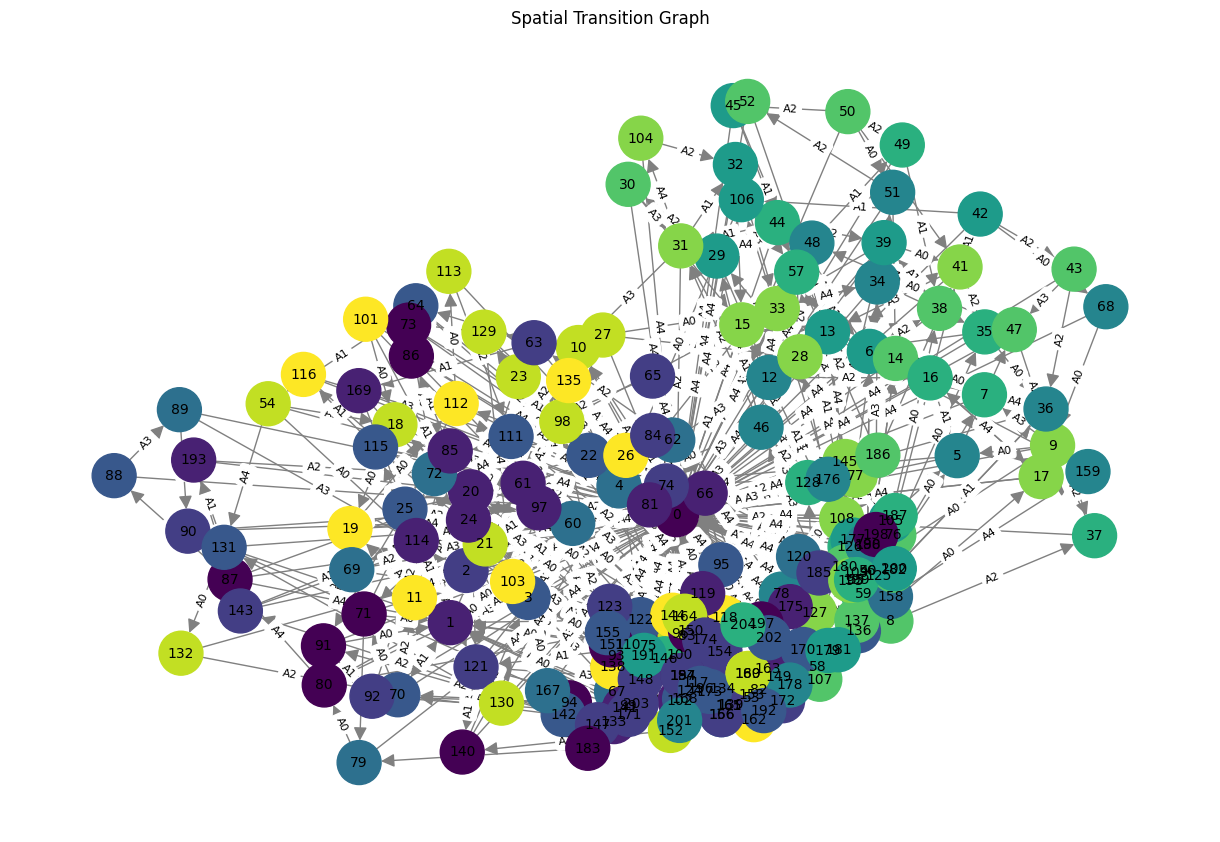

In [47]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example transition matrix (state, state, action)
# transition_matrix = agent.TM
TM=viterbi_decoding(agent)
# TM = agent.TM
num_states = np.shape(TM)[0]
num_actions = np.shape(TM)[2]

# Threshold to show only significant transitions
threshold = 0.9

# Create a directed graph
G = nx.DiGraph()

# Add nodes for each state
for state in range(num_states):
    G.add_node(state)

# Add edges based on the transition matrix
for action in range(num_actions):
    for from_state in range(num_states):
        for to_state in range(num_states):
            weight = TM[from_state, to_state, action]
            if weight > threshold:  # Filter out weak transitions
                G.add_edge(
                    from_state,
                    to_state,
                    weight=weight,
                    label=f"A{action}"  # Label edges by action
                )

# Use Kamada-Kawai layout for a more spatially balanced layout
pos = nx.kamada_kawai_layout(G)  # Alternative layouts: spring_layout, shell_layout

# Node colors based on clone_map (or any observation data)
node_colors = [t[0] for t in clone_map]  # Replace with your actual node color logic

# color_map = {0: 'pink', 1: 'skyblue', 2: 'green', 3: 'orange'}  # Observation to color mapping
# node_colors = [color_map[val] for val in node_colors]  # Flatten room to assign colors to each cell
# node_colors = [color_map[val] for val in node_colors]  # Flatten room to assign colors to each cell

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,  # Use the color scheme for nodes
    node_size=1000,
    font_size=10,
    edge_color='gray',
    arrowsize=20
)

# Draw edge labels
edge_labels = nx.get_edge_attributes(G, 'label')
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=8
)

plt.title("Spatial Transition Graph")
plt.axis('off')  # Turn off axes for cleaner visualization
plt.show()


In [ ]:
# action from one state to other should be more deterministic?
# draw this graph thresholded 
# like viterbi decoding, only draw the highest prob. action (1 or 0) -- binarize the TM

In [478]:
agent.groups_of_tables

{0: {0: 297,
  1: 22,
  2: 36,
  3: 48,
  4: 66,
  5: 228,
  6: 31,
  7: 258,
  8: 6,
  9: 11,
  10: 7,
  11: 9,
  12: 5,
  13: 6,
  14: 4,
  15: 8},
 1: {0: 259, 1: 337, 2: 111, 3: 42, 4: 108, 5: 681},
 2: {0: 50,
  1: 106,
  2: 40,
  3: 63,
  4: 36,
  5: 50,
  6: 419,
  7: 3,
  8: 13,
  9: 250,
  10: 14,
  11: 17},
 3: {0: 322, 1: 242, 2: 359, 3: 96, 4: 76, 5: 5, 6: 128, 7: 133}}

In [488]:
for t in range(4):
    print(len(agent.groups_of_tables[t]))

16
6
12
8


In [481]:
# Count unique elements and their frequencies
np.unique(room, return_counts=True)

(array([0, 1, 2, 3]), array([10, 16, 10, 12]))

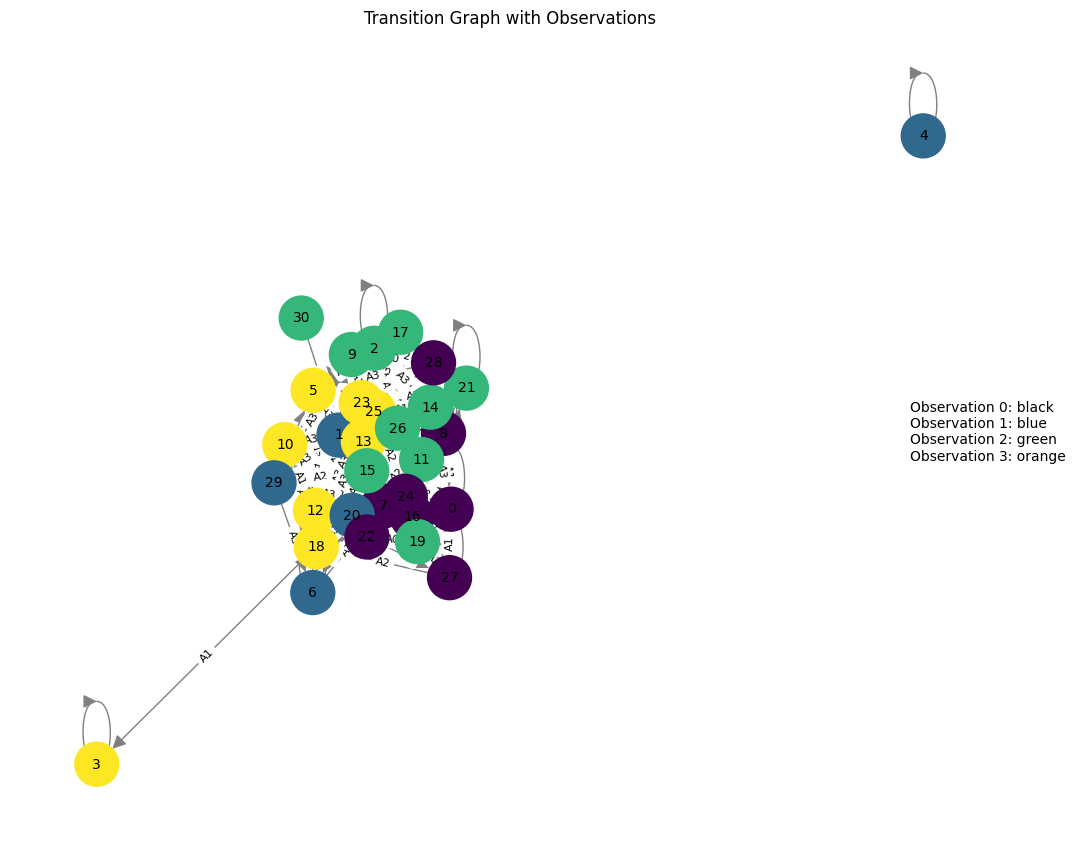

In [219]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Example transition matrix (state, state, action)
transition_matrix = agent.TM
num_states = np.shape(agent.TM)[0]
num_actions = np.shape(agent.TM)[2]
# transition_matrix = np.random.rand(num_states, num_states, num_actions)

# Threshold to show only significant transitions
threshold = 0.1

# Example observations for each state (one of four categories)
# Replace with your actual observations
# observations = [0, 1, 2, 3, 1]  # Each state is assigned to an observation
# color_map = {0: 'red', 1: 'blue', 2: 'green', 3: 'orange'}  # Observation to color mapping

# Assign colors to states based on observations
# node_colors = [color_map[obs] for obs in observations]
node_colors = [t[0] for t in clone_map]
# Create a directed graph
G = nx.DiGraph()

# Add nodes for each state
for state in range(num_states):
    G.add_node(state)

# Add edges based on the transition matrix
for action in range(num_actions):
    for from_state in range(num_states):
        for to_state in range(num_states):
            weight = transition_matrix[from_state, to_state, action]
            if weight > threshold:  # Filter out weak transitions
                G.add_edge(
                    from_state,
                    to_state,
                    weight=weight,
                    label=f"A{action}"  # Label edges by action
                )

# Draw the graph
pos = nx.spring_layout(G)  # Position nodes using a spring layout
edge_labels = nx.get_edge_attributes(G, 'label')  # Get edge labels

plt.figure(figsize=(10, 8))
nx.draw(
    G,
    pos,
    with_labels=True,
    node_color=node_colors,  # Use the color scheme for nodes
    node_size=1000,
    font_size=10,
    edge_color='gray',
    arrowsize=20
)
nx.draw_networkx_edge_labels(
    G,
    pos,
    edge_labels=edge_labels,
    font_size=8
)

# Add a legend for the color scheme
legend_labels = [f"Observation {obs}: {color}" for obs, color in color_map.items()]
legend_text = "\n".join(legend_labels)
plt.gcf().text(0.9, 0.5, legend_text, fontsize=10, va='center')

plt.title("Transition Graph with Observations")
plt.show()


<Axes: >

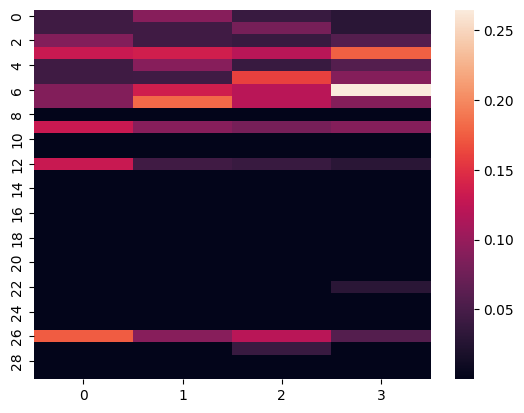

In [211]:
import seaborn as sns
sns.heatmap(agent.TM[:][0][:])

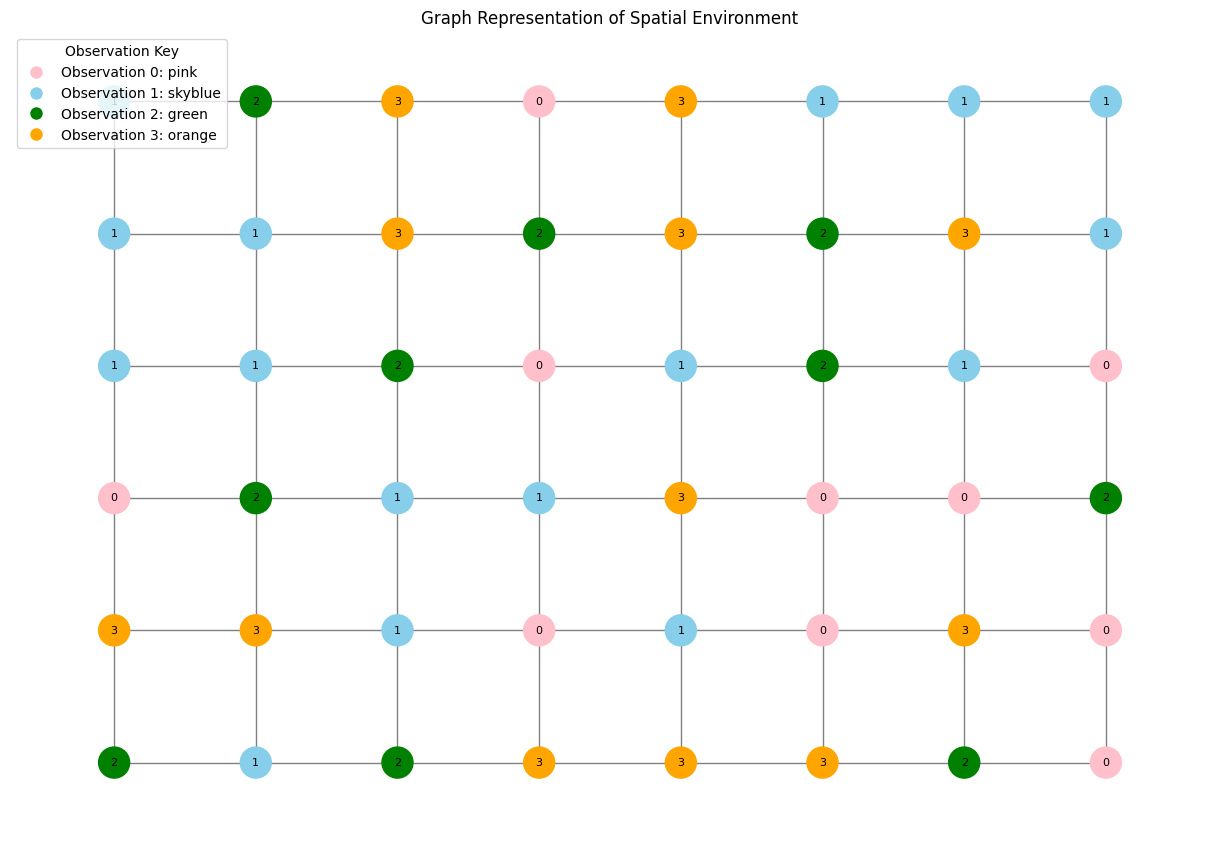

In [484]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Ground-truth environment
room = np.array(
    [
        [1, 2, 3, 0, 3, 1, 1, 1],
        [1, 1, 3, 2, 3, 2, 3, 1],
        [1, 1, 2, 0, 1, 2, 1, 0],
        [0, 2, 1, 1, 3, 0, 0, 2],
        [3, 3, 1, 0, 1, 0, 3, 0],
        [2, 1, 2, 3, 3, 3, 2, 0],
    ]
)

# Define the color map for observations
color_map = {0: 'pink', 1: 'skyblue', 2: 'green', 3: 'orange'}  # Observation to color mapping
node_colors = [color_map[val] for val in room.flatten()]  # Flatten room to assign colors to each cell


# Create a graph
rows, cols = room.shape
GT = nx.Graph()

# Add nodes
for r in range(rows):
    for c in range(cols):
        node_id = (r, c)
        GT.add_node(node_id, observation=room[r, c])

# Add edges for neighbors (up, down, left, right)
for r in range(rows):
    for c in range(cols):
        if r > 0:  # Connect to the cell above
            GT.add_edge((r, c), (r-1, c))
        if r < rows - 1:  # Connect to the cell below
            GT.add_edge((r, c), (r+1, c))
        if c > 0:  # Connect to the cell to the left
            GT.add_edge((r, c), (r, c-1))
        if c < cols - 1:  # Connect to the cell to the right
            GT.add_edge((r, c), (r, c+1))

# Position nodes in a grid layout
pos = {(r, c): (c, -r) for r in range(rows) for c in range(cols)}  # Flip y-axis for grid alignment

# Draw the graph
plt.figure(figsize=(12, 8))
nx.draw(
    GT,
    pos,
    with_labels=True,
    labels={(r, c): f"{room[r, c]}" for r in range(rows) for c in range(cols)},  # Show observation value
    node_color=node_colors,  # Use colors based on observations
    node_size=500,
    font_size=8,
    edge_color='gray'
)

# Add a legend
legend_labels = [f"Observation {obs}: {color}" for obs, color in color_map.items()]
legend_patches = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10)
                  for color in color_map.values()]
plt.legend(legend_patches, legend_labels, loc='upper left', title="Observation Key")

plt.title("Graph Representation of Spatial Environment")
plt.axis('off')
plt.show()


In [ ]:
room

In [ ]:
############# Before putting it to agent.forward_algorithm #############    
#     prior = get_distribution(agent.groups_of_tables)
#     print(prior)

#     num_steps = len(observations)
#     num_states = len(prior)
# #     forward_probs = np.zeros((num_states, num_steps)) # n total clone, sequence length
#     log_forward_probs = np.full((num_states, num_steps), 0)  # Use -inf for log(0)

#     initial_state = observations[0]
#     for s in range(num_states):
#         if s == initial_state:
# #             forward_probs[s, 0] = prior[s]
#             log_forward_probs[s,0] = prior[s]
#         else:
# #             forward_probs[s, 0] = 0  # Probability is zero if it doesn't match initial state
#             log_forward_probs[s,0] = 0


#     for t in range(1, num_steps):
#         current_clone = [clone[2] for clone in clone_map 
#                          if clone[0]==clone_history[t][0] and clone[1]==clone_history[t][1]]

#         prev_action = actions[t-1]

#         for s in range(num_states):
#                 log_forward_probs[s, t] = np.logaddexp.reduce([
#                     log_forward_probs[prev_s, t-1] + np.log(agent.TM[prev_s, s, prev_action])
#                     for prev_s in range(num_states)
#                 ])
#     print(np.sum(log_forward_probs))
############################################################################## 

In [59]:
agent.groups_of_tables

{0: {0: 7895, 1: 1149, 2: 281, 3: 574, 4: 384, 5: 37, 6: 84, 7: 2, 8: 1, 9: 4},
 1: {0: 1609,
  1: 2627,
  2: 9015,
  3: 437,
  4: 1299,
  5: 103,
  6: 202,
  7: 75,
  8: 3,
  9: 1},
 2: {0: 6839, 1: 1606, 2: 784, 3: 457, 4: 365, 5: 529, 6: 20, 7: 1},
 3: {0: 1234, 1: 437, 2: 9871, 3: 427, 4: 1531, 5: 51, 6: 40, 7: 9, 8: 1}}

In [57]:
print(clone_map)

[(0, 0, 0), (1, 0, 1), (2, 0, 2), (3, 0, 3), (1, 1, 4), (3, 1, 5), (1, 2, 6), (0, 1, 7), (3, 2, 8), (2, 1, 9), (0, 2, 10), (0, 3, 11), (0, 4, 12), (1, 3, 13), (2, 2, 14), (3, 3, 15), (2, 3, 16), (3, 4, 17), (1, 4, 18), (1, 5, 19), (2, 4, 20), (2, 5, 21), (1, 6, 22), (0, 5, 23), (0, 6, 24), (1, 7, 25), (3, 5, 26), (3, 6, 27), (2, 6, 28), (1, 8, 29), (0, 7, 30), (3, 7, 31), (0, 8, 32), (0, 9, 33), (2, 7, 34), (1, 9, 35), (3, 8, 36)]


In [10]:
clone_map

[(0, 0), (1, 0), (2, 0), (3, 0)]

In [31]:
np.sum(forward_probs)

0.08782435129740519

In [181]:
observations[0]

3

In [ ]:
agent.get_total_observations()

In [33]:
for i in range(4):
#     curr_
    print(agent.get_restaurant_total_customers(i))

184
296
222
300


In [158]:
[agent.get_restaurant_total_customers(i)/agent.get_total_observations() for i in range(4)]

[0.18518518518518517,
 0.2962962962962963,
 0.2222222222222222,
 0.3003003003003003]

In [154]:
agent.get_prior_distribution()

[0.0]

In [56]:
for i in range(4): 
    print(agent.count_tables_in_restaurant(i))

10
10
8
9


# Problems to consider: 
1. TM size is +4 the number of clones
2. sum of probs (PE) doesn't necessarily have to be less than 1 but seems so. Why?

In [149]:
clone_history

[(3, 0),
 (1, 1),
 (3, 1),
 (1, 2),
 (0, 1),
 (2, 1),
 (3, 2),
 (2, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (2, 3),
 (3, 3),
 (2, 0),
 (1, 0),
 (1, 2),
 (1, 3),
 (1, 4),
 (1, 0),
 (1, 4),
 (0, 2),
 (3, 4),
 (3, 5),
 (3, 5),
 (2, 4),
 (2, 3),
 (2, 1),
 (3, 6),
 (3, 6),
 (3, 7),
 (3, 8),
 (2, 5),
 (3, 6),
 (3, 8),
 (3, 9),
 (3, 8),
 (0, 2),
 (1, 5),
 (0, 3),
 (1, 6),
 (3, 7),
 (1, 7),
 (3, 10),
 (3, 7),
 (1, 2),
 (0, 1),
 (3, 8),
 (0, 2),
 (2, 6),
 (0, 2),
 (2, 7),
 (0, 2),
 (2, 5),
 (0, 4),
 (3, 6),
 (0, 1),
 (0, 0),
 (2, 8),
 (2, 5),
 (3, 8),
 (2, 1),
 (0, 1),
 (3, 0),
 (3, 6),
 (2, 9),
 (0, 2),
 (1, 3),
 (2, 10),
 (1, 8),
 (2, 5),
 (1, 9),
 (2, 4),
 (1, 10),
 (0, 5),
 (3, 11),
 (0, 1),
 (3, 12),
 (0, 2),
 (3, 5),
 (0, 2),
 (3, 13),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 2),
 (0, 1),
 (3, 2),
 (2, 1),
 (2, 1),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 2),
 (0, 6),
 (0, 2),
 (0, 2),
 (2, 1),
 (3, 3),
 (0, 0),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 1),
 (0, 2),
 (0, 1),
 (0, 2),
 (0, 2),
 (0, 2),
 (0,

In [167]:
data= agent.groups_of_tables

In [169]:
def get_distribution(data):
    """
    Compute the probability distribution from a nested dictionary structure.

    Parameters:
        data (dict): A nested dictionary where the outer keys map to inner dictionaries
                     containing counts for different elements.

    Returns:
        np.ndarray: A NumPy array containing the probability distribution.
    """
    # Flatten the dictionary and compute total count
    flattened_counts = defaultdict(int)
    total_count = 0

    for outer_key, inner_dict in data.items():
        for inner_key, count in inner_dict.items():
            flattened_counts[inner_key] += count
            total_count += count

    # Compute probabilities as a sorted NumPy array
    sorted_keys = sorted(flattened_counts.keys())
    probabilities = np.array([flattened_counts[key] / total_count for key in sorted_keys])

    return probabilities


In [174]:
get_distribution(data)


(array([0.06181456, 0.11864407, 0.13160518, 0.06380857, 0.0558325 ,
        0.08175474, 0.09770688, 0.01595214, 0.05184447, 0.02093719,
        0.04885344, 0.03190429, 0.02093719, 0.01395813, 0.01595214,
        0.00697906, 0.02691924, 0.01894317, 0.01296112, 0.01196411,
        0.00498504, 0.00697906, 0.00598205, 0.00498504, 0.00797607,
        0.00498504, 0.00697906, 0.00598205, 0.00498504, 0.00598205,
        0.00299103, 0.00398804, 0.00299103, 0.00398804, 0.00199402,
        0.00398804, 0.00598205, 0.00099701, 0.00099701, 0.00099701,
        0.00099701, 0.00099701]),
 2)

In [146]:
np.shape(agent.TM)

(27, 27, 4)

In [119]:
clone_history

[]

### General intuition
At first, many clones will be splitted out due to vanilla transition matrix

But this will be corrected with merging

With more experience and more accurate transition matrices, splitting and merging will diminish

we can end whenever the likelihood plataeus. 


In [70]:
import random
random.sample([1,2],1)

[1]

In [63]:
container.groups_of_tables

{3: {0: 37, 1: 983, 2: 235, 3: 81, 4: 19, 5: 5, 6: 1},
 1: {0: 773, 1: 710, 2: 17, 3: 35, 4: 3},
 0: {0: 914, 1: 9, 2: 54, 3: 16, 4: 6, 5: 4, 6: 24, 7: 7, 8: 1, 9: 2, 10: 4},
 2: {0: 280, 1: 611, 2: 128, 3: 33, 4: 2, 5: 5, 6: 1}}

In [66]:
n_clones

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
PEs = np.array([np.sum(T_tr[a[t-1], old_ind, state_loc[i]:state_loc[i+1]]) for i in range(len(state_loc)-1)])
if len(state_loc) < 5: ####CHECK THIS PART LATER
    PEs = np.append(PEs, np.sum(T_tr[a[t-1], old_ind, state_loc[-1]:]))
PEs_softmax = softmax(PEs)
PE = PEs_softmax[ind]

In [33]:
n_clones

array([1, 1, 1, 1, 1, 1])

In [36]:
container.get_group_total(0)

2

In [38]:
container.get_total_observations()

11

In [ ]:
class splitMerge: 
    def __init__(self, alpha=1.0, depth=3):
    # splitting
    self.alpha = alpha   # Dispersion parameter for CRP
    self.depth = depth   # Maximum depth of the tree
    self.tree = defaultdict(lambda: defaultdict(int))  # Tracks customer counts at each node
    # merging
#         def __init__(self, num_states, transition_probs, emission_probs, alpha=1.0):
    self.num_states = num_states
    self.transition_probs = transition_probs
    self.emission_probs = emission_probs
    self.alpha = alpha  # Dirichlet prior